<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 994.7 kB/s eta 0:00:00


### Download Humpback Whale Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [00:56<00:00, 148MB/s]
100% 5.51G/5.51G [00:56<00:00, 105MB/s]


In [4]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [1]:
import os

if os.path.exists('/content/creating-ai-enabled-systems/Research Project') == False:
  !git clone https://github.com/jwells52/creating-ai-enabled-systems.git

%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [2]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot, MatchingNetworks, RelationNetworks
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loader
from modules.train import train_fsl, device, transform


%load_ext autoreload
%autoreload 2

In [3]:
n_way   = 5
n_shot  = 5
n_query = 5

In [4]:
transform

Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(256, 512), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### Look at classes that have low performance

In [9]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [5]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
)

df = df[df.class_count >= 10]

In [6]:
dataset = HumpbackWhaleDataset('/content/train', df, transform=transform)

In [12]:
sampler = TaskSampler(
    dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=500
)

In [13]:
loader = DataLoader(
    dataset,
    batch_sampler=sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=sampler.episodic_collate_fn
)


In [14]:
cnn = resnet18()
cnn.fc = torch.nn.Flatten()
few_shot_classifier = PrototypicalNetworks(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/Research-Project/models/prototypical_network_resnet18_prod_last_epoch')()
)

<All keys matched successfully>

In [15]:
next(iter(loader))[0].shape

torch.Size([25, 3, 256, 512])

In [16]:
%%capture

few_shot_classifier.eval()

In [29]:
task_accs = {'<25%': dict(), '25-50%': dict(), '50-75%': dict(), '>75%': dict()}
task_images = {'<25%': dict(), '25-50%': dict(), '50-75%': dict(), '>75%': dict()}

n_tasks = 250
for task in tqdm(range(n_tasks)):
  # Sample n_way random whale_ids
  whale_ids = np.random.choice(df['Id'].unique(), size=n_way, replace=False)

  # Sample n_shot images for each whale_id for support set
  task_support_labels = []
  task_support_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    task_support_image_paths.extend(list(np.random.choice(df[df['Id'] == whale_id]['Image'], size=5, replace=False)))
    task_support_labels.extend([i for _ in range(n_shot)])


  # Sample n_shot images for each whale_id for query set
  task_query_labels = []
  task_query_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    whale_query_images = df[(df['Id'] == whale_id) & ~(df['Image'].isin(task_support_image_paths))]['Image']
    task_query_image_paths.extend(list(np.random.choice(whale_query_images, size=n_query, replace=False)))
    task_query_labels.extend([i for _ in range(n_query)])

  # Load images and labels in tensor
  support_images = np.zeros((n_shot*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_support_image_paths):
    support_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()

  query_images = np.zeros((n_query*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_query_image_paths):
    query_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()


  # Turn all images and labels into tensors
  support_labels = torch.Tensor(task_support_labels)
  support_images = torch.Tensor(support_images)
  query_labels = torch.Tensor(task_query_labels)
  query_images = torch.Tensor(query_images)


  # Pass support and query sets through Prototypical Network
  few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
  predictions = few_shot_classifier(query_images.to(device)).detach().data
  prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data

  for label in torch.unique(query_labels):
    label_idxs = torch.argwhere(query_labels == label)
    whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / n_query
    whale_id = whale_ids[int(label.detach().item())]

    if whale_id not in task_accs: task_accs[whale_id] = []
    if whale_id not in task_images: task_images[whale_id] = []

    if whale_id_acc < 0.25:
      if whale_id not in task_images['<25%']:
        task_images['<25%'][whale_id] = []

      task_images['<25%'][whale_id] += [[task_support_image_paths[i] for i in label_idxs]]

    elif whale_id_acc >= 0.25 and whale_id_acc < 0.5:
      if whale_id not in task_images['25-50%']:
        task_images['25-50%'][whale_id] = []

      task_images['25-50%'][whale_id] += [[task_support_image_paths[i] for i in label_idxs]]

    elif whale_id_acc >= 0.5 and whale_id_acc < 0.75:
      if whale_id not in task_images['50-75%']:
        task_images['50-75%'][whale_id] = []

      task_images['50-75%'][whale_id] += [[task_support_image_paths[i] for i in label_idxs]]

    else:
      if whale_id not in task_images['>75%']:
        task_images['>75%'][whale_id] = []

      task_images['>75%'][whale_id] += [[task_support_image_paths[i] for i in label_idxs]]


100%|██████████| 250/250 [03:51<00:00,  1.08it/s]


In [42]:
task_images['50-75%']['w_83a4279']

[['3b66bd85d.jpg',
  '97f8e9101.jpg',
  '3ccfa4891.jpg',
  '522897d8b.jpg',
  '41e398a98.jpg']]

In [ ]:
# Look at whale_ids that are in the lower spectrum of the histogram

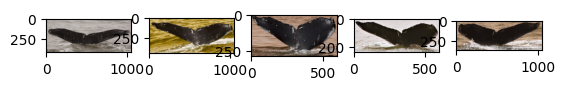

In [43]:
fig, axs = plt.subplots(1, 5)
for i, image in enumerate(task_images['50-75%']['w_83a4279'][0]):
  # for j in range(5):
  axs[i].imshow(cv2.imread(f'/content/train/{image}'))

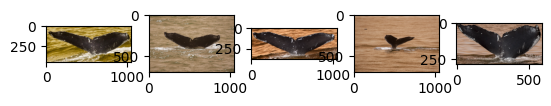

In [41]:
fig, axs = plt.subplots(1, 5)
for i, image in enumerate(task_images['25-50%']['w_83a4279'][0]):
  # for j in range(5):
  axs[i].imshow(cv2.imread(f'/content/train/{image}'))

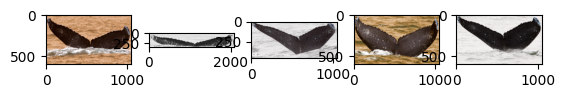

In [36]:
fig, axs = plt.subplots(1, 5)
for i, image in enumerate(task_images['<25%']['w_698fcbe'][0]):
  # for j in range(5):
  axs[i].imshow(cv2.imread(f'/content/train/{image}'))

In [ ]:
fig, axs = plt.subplots(1, 5)
for i, image in enumerate(task_images['<25%']['w_698fcbe'][0]):
  # for j in range(5):
  axs[i].imshow(cv2.imread(f'/content/train/{image}'))

In [ ]:
lpc_mean_heights = []
lpc_mean_widths  = []

for lpc in low_performance_classes:
  lpc_mean_heights += [np.mean([h for h, _ in low_performance_images[lpc]])]
  lpc_mean_widths  += [np.mean([w for _, w in low_performance_images[lpc]])]



In [ ]:
print(np.mean(lpc_mean_heights))
print(np.mean(lpc_mean_widths))

536.815291858679
1005.0294546850998


In [ ]:
hpc_mean_heights = []
hpc_mean_widths  = []

for hpc in high_performance_classes:
  hpc_mean_heights += [np.mean([h for h, _ in high_performance_images[hpc]])]
  hpc_mean_widths  += [np.mean([w for _, w in high_performance_images[hpc]])]

In [ ]:
print(np.mean(hpc_mean_heights))
print(np.mean(hpc_mean_widths))

506.19290079535534
1020.3927176454685


Look at matching networks

In [7]:
cnn = resnet18(weights='DEFAULT')
cnn.fc = torch.nn.Flatten()
cnn = cnn.to(device)

In [10]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    num_workers=2,
    shuffle=False,
)

In [11]:
from easyfsl.utils import predict_embeddings

embeddings_df = predict_embeddings(dataloader, cnn, device=device)

print(embeddings_df)

Predicting embeddings: 100%|██████████| 301/301 [01:07<00:00,  4.46batch/s]


                                              embedding  class_name
0     [tensor(0.3049), tensor(0.6598), tensor(1.1811...           0
1     [tensor(1.1953), tensor(1.3426), tensor(0.9337...           1
2     [tensor(1.1288), tensor(0.5041), tensor(0.6378...           2
3     [tensor(0.4303), tensor(0.9968), tensor(0.8337...           3
4     [tensor(0.5984), tensor(0.6052), tensor(1.1637...           4
...                                                 ...         ...
4809  [tensor(1.4665), tensor(1.1089), tensor(0.9222...          51
4810  [tensor(1.3393), tensor(0.7167), tensor(0.4624...         100
4811  [tensor(0.3397), tensor(0.5378), tensor(1.2134...          13
4812  [tensor(0.7806), tensor(1.6399), tensor(1.8509...           7
4813  [tensor(1.0464), tensor(0.4973), tensor(0.2367...         205

[4814 rows x 2 columns]


In [12]:
from easyfsl.datasets import FeaturesDataset

features_dataset = FeaturesDataset.from_dataframe(embeddings_df)

In [13]:
task_sampler = TaskSampler(
    features_dataset,
    n_way=5,
    n_shot=5,
    n_query=5,
    n_tasks=100,
)
features_loader = DataLoader(
    features_dataset,
    batch_sampler=task_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=task_sampler.episodic_collate_fn,
)

In [69]:
mn_classifier = MatchingNetworks(cnn, feature_dimension=512).to(device)

In [74]:
acc = evaluate(
    mn_classifier, loader, device=device, use_tqdm=True
)


100%|██████████| 500/500 [06:27<00:00,  1.29it/s, accuracy=0.576]


In [14]:
pt_classifier = PrototypicalNetworks(torch.nn.Identity()).to(device)

In [17]:
acc = evaluate(
    pt_classifier, features_loader, device=device, use_tqdm=True
)

100%|██████████| 100/100 [00:01<00:00, 68.51it/s, accuracy=0.625]


In [82]:
ss_classifier = SimpleShot(cnn).to(device)

In [83]:
acc = evaluate(
    ss_classifier, loader, device=device, use_tqdm=True
)

 40%|████      | 202/500 [02:36<03:50,  1.29it/s, accuracy=0.594]


KeyboardInterrupt: ignored